## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [3]:
PATH = 'data/planet/'

In [ ]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

In [4]:
ls {PATH}

Kaggle-planet-test-tif.torrent   test-jpg.tar.7z
Kaggle-planet-train-tif.torrent  test-tif-v2.tar.7z
__MACOSX/                        test_v2_file_mapping.csv
models/                          train-jpg.tar.7z
sample_submission_v2.csv         train-tif-v2.tar.7z
test-jpg-additional.tar.7z       train_v2.csv


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

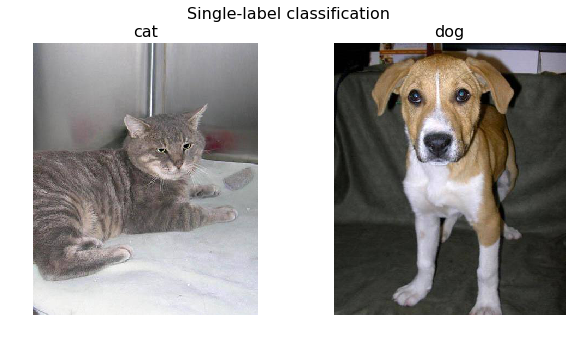

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

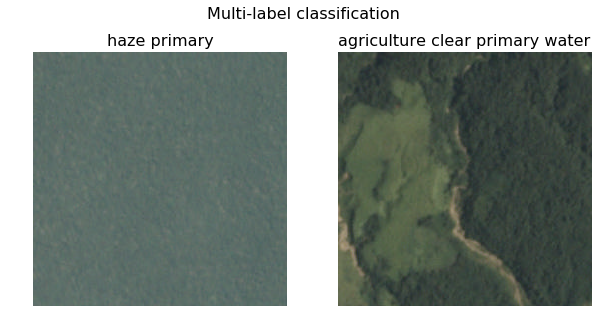

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 1.0),
 ('water', 1.0)]

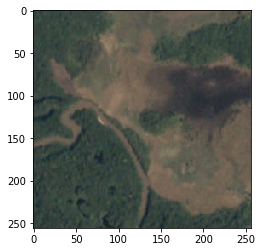

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

A Jupyter Widget

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

A Jupyter Widget

[ 0.       0.23047  0.31738  0.81073]                        



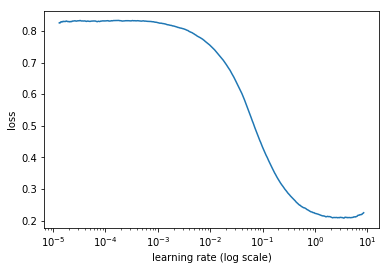

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.14765  0.1322   0.88361]                        
[ 1.       0.14164  0.12535  0.89197]                        
[ 2.       0.1364   0.12387  0.89349]                        
[ 3.       0.14337  0.12293  0.89585]                        
[ 4.       0.13762  0.12143  0.89538]                        
[ 5.       0.13502  0.12     0.89885]                        
[ 6.       0.13356  0.11931  0.89819]                        



In [25]:
lrs = np.array([lr/9,lr/3,lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.12184  0.10543  0.91165]                        
[ 1.       0.11441  0.1026   0.91267]                        
[ 2.       0.10713  0.09748  0.91847]                        
[ 3.       0.11264  0.0981   0.91715]                        
[ 4.       0.10863  0.09575  0.91991]                        
[ 5.       0.10079  0.09414  0.92076]                        
[ 6.       0.10045  0.0928   0.92266]                         



In [27]:
learn.save(f'{sz}')

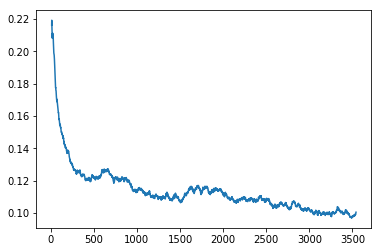

In [28]:
learn.sched.plot_loss()

In [29]:
sz=128

In [30]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.10296  0.08952  0.92601]                         
[ 1.       0.0982   0.08833  0.92644]                         
[ 2.       0.09869  0.08771  0.92734]                         
[ 3.       0.09855  0.08828  0.92617]                         
[ 4.       0.09869  0.08723  0.9269 ]                         
[ 5.       0.09787  0.08665  0.92868]                         
[ 6.       0.0969   0.08669  0.92838]                         



In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09679  0.08347  0.93117]                         
[ 1.       0.09365  0.08352  0.9306 ]                         
[ 2.       0.08949  0.08126  0.93365]                         
[ 3.       0.09448  0.08385  0.93145]                         
[ 4.       0.09069  0.08292  0.93225]                         
[ 5.       0.08634  0.08026  0.93465]                         
[ 6.       0.08396  0.08021  0.93417]                         



In [32]:
sz=256

In [33]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09201  0.08433  0.92878]                         
[ 1.       0.09249  0.08349  0.93041]                         
[ 2.       0.09279  0.08293  0.93029]                         
[ 3.       0.08976  0.08314  0.93019]                         
[ 4.       0.0894   0.0822   0.93217]                         
[ 5.       0.09079  0.08206  0.93139]                         
[ 6.       0.08857  0.08199  0.93155]                         



In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08807  0.07949  0.93532]                         
[ 1.       0.08838  0.08112  0.93301]                         
[ 2.       0.08523  0.07841  0.93603]                         
[ 3.       0.08967  0.08051  0.93312]                         
[ 4.       0.08474  0.07945  0.93629]                         
[ 5.       0.08156  0.07828  0.93557]                         
[ 6.       0.07787  0.0778   0.93657]                         



In [35]:
tta = learn.TTA()

In [36]:
f2(*tta)

0.93385037821388817

### End